In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import os, sys, datetime, time
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
from torchvision import transforms as tvtransforms
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import torch.utils.tensorboard as tensorboard
import torch.nn as nn

# Own functions
from dataloaders import Dataset_CTCovid19August2020, Dataset_PolyU_CXR
import transforms
import blocks

# Flags:
flag_debug = False

# Input directories
DRR_directory = "G:\DanielLam\CT-Covid-19-August2020\DRR_output"
CXR_directory = "G:\DanielLam\POLYU_COVID19_CXR_CT_Cohort1"

# Save directories
output_save_directory = Path("./runs/ResUNetGenerator_MSADiscriminator_v6/")
output_save_directory.mkdir(parents=True, exist_ok=True)
PATH_G = os.path.join(output_save_directory, "netG.pt") # path to save weights for generator
PATH_D = os.path.join(output_save_directory, "netD.pt") # path to save weights for discriminator

# Settings for training:
num_epochs = 10 # Isola et al. Image-to-Image Translation with CGANs
_batch_size = 3 # 1 per GPU at least
discriminator_keys_images = ["source", "boneless", "lung"]
generator_keys_images = ["source"]
generator_target = "boneless"
image_spatial_size = (512,512)

# Adam Optimiser
# Parameters from: Isola et al. 2016 Image-to-Image Translation
lr = 0.0002
beta1=0.5
beta2=0.999
"""
# Parameters from: Diakogiannis et al. ResUNet-A paper
lr = 0.001
beta1 = 0.9
beta2 = 0.999
"""
# Decide which device we want to run on
ngpu = 3
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2"
print(device)
# Current date:
current_date=datetime.datetime.today().strftime('%Y-%m-%d')

cuda


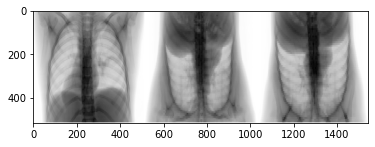

In [2]:
# Set up datasets and dataloaders
ds_discriminator = Dataset_CTCovid19August2020(os.path.join(DRR_directory,"DRR_directory.csv"), 
                                               os.path.join(DRR_directory), 
                                 transform=tvtransforms.Compose([
                                     transforms.Rescale(image_spatial_size, discriminator_keys_images, "PixelSize"),
                                     transforms.RescalingNormalisation(discriminator_keys_images),
                                     transforms.Random180(discriminator_keys_images, probability=0.5),
                                     transforms.ToTensor(discriminator_keys_images),
                                     ]))

ds_generator = Dataset_PolyU_CXR(Path(CXR_directory),
                                 transform=tvtransforms.Compose([
                                     transforms.Rescale(image_spatial_size, generator_keys_images, "PixelSize"),
                                     transforms.ImageComplement(generator_keys_images),
                                     transforms.RescalingNormalisation(generator_keys_images),
                                     transforms.ToTensor(generator_keys_images),
                                     ]))

dl_training = DataLoader(ds_discriminator, batch_size=_batch_size,
                        shuffle=True, num_workers=0)
dl_testing = DataLoader(ds_generator, batch_size=_batch_size,
                        shuffle=True, num_workers=0)

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

        
# get some random training images
dataiter = iter(dl_training)
sample = dataiter.next()
# create grid of images
img_grid = vutils.make_grid(sample["source"])
# show images
matplotlib_imshow(img_grid, one_channel=True)


In [3]:
# Implementation of Network
def weights_init(m):
    # From DCGAN paper
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        if m.affine:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    
    for i in m.children():
        # Specific weight setting for ResUNet shortcut.
        if i.__class__.__name__ == "ResUNet_shortcut":
            for ii in i.children():
                if isinstance(ii, nn.Conv2d) or isinstance(ii, nn.ConvTranspose2d):
                    nn.init.constant_(ii.weight.data, 1.)
            for param in i.parameters():
                param.requires_grad=False


# Network Structure
_initial_channels_out = 32 # Diakogiannis et al. ResUNet-A: A deep learning framework for semantic segmentation of remotely-sensed data
_input_array_shape_classifier = (_batch_size, 2 , image_spatial_size[0], image_spatial_size[1])  # 2 channels -- channel 0 for source, channel 1 for real/fake boneless
_input_array_shape_generator = (_batch_size, 1 , image_spatial_size[0], image_spatial_size[1])


netG = blocks.Generator_ResUNet_modified(_input_array_shape_generator, _first_out_channels=64,
                                _reluType="leaky", _dropoutType="ADL", _drop_rate=0.5)
"""
netG = blocks.Generator_Pix2Pix(_input_array_shape_generator, 
                                _normType="BatchNorm", _dropoutType = "ADL", _dropRate=0.5)

netG = blocks.Generator_ResUNet_A(_input_channels=_initial_channels_out, _input_array_shape=_input_array_shape_generator,
                                  _norm_type='BatchNorm', _ADL_drop_rate=0.75, _ADL_gamma=0.9)
"""
netD = blocks.MultiScale_Classifier(_input_channels=_initial_channels_out, _input_array_shape=_input_array_shape_classifier,
                                    _classifier_out_channels=64,
                                    _norm_type='BatchNorm', _ADL_drop_rate=0.75, _ADL_gamma=0.9)

# Initialise weights
netG.apply(weights_init)
netD.apply(weights_init)

# Multi-GPU
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    netD = nn.DataParallel(netD, list(range(ngpu)))

netG = netG.to(device)
netD = netD.to(device)

# Loss Function
def criterion_generator(input_image, ground_truth_image, input_label, ground_truth_label, reg_lambda=100):
    L_cGAN = nn.BCELoss(reduction="mean")
    L_l1 = nn.L1Loss(reduction="mean")
    return L_cGAN(input_label , ground_truth_label) + reg_lambda*L_l1(input_image , ground_truth_image)
def criterion_discriminator(input_label, ground_truth_label):
    L_cGAN = nn.BCELoss(reduction="mean")
    return L_cGAN(input_label, ground_truth_label)

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))

# print(netG)

In [4]:
## Training Loop

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Fixed Test Sample
dl_test = DataLoader(ds_generator, batch_size=1,
                        shuffle=False, num_workers=0)
fixed_test_image = next(iter(dl_test))

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0


print("Beginning Training...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dl_training):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        
        # Generate fake image batch with G
        conditioning_data = data['source'].to(device)
        fake = netG(conditioning_data)    
        fake = fake.cpu()
        
        ## Train with all-real batch
        netD.zero_grad()
        # Condition the data
        b_data = torch.cat((data['source'], data[generator_target]), dim=1)
        real_cpu = b_data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = 0.5*criterion_discriminator(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        ## Train with all-fake batch
        label.fill_(fake_label)
        b_data = torch.cat((data['source'] , fake.detach()), dim=1)
        fake_cpu = b_data.to(device)
        # Classify all fake batch with D
        # Fake is detached because the .backwards() command destroys parts of the computational graph
        output = netD(fake_cpu).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = 0.5*criterion_discriminator(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        # fake CANNOT be detached here.
        b_data = torch.cat((data['source'] , fake), dim=1)
        fake_cpu = b_data.to(device)
        output = netD(fake_cpu).view(-1)
        # Calculate G's loss based on this output
        errG = criterion_generator(fake.detach(), data[generator_target], output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x,z): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dl_training),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on a fixed test image
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dl_training)-1)):
            with torch.no_grad():
                fake = netG(fixed_test_image['source']).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        
        if flag_debug and i == 2:
            print(iters)
            print("DEBUGGING -- REMOVE THIS IF CONDITION IN FULL TEST")
            break
    if flag_debug and epoch == 2:
        print("DEBUGGING -- REMOVE THIS IF CONDITION IN FULL TEST")
        break



Beginning Training...


C:\Users\Y1112\anaconda3\envs\daniel\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


[0/10][0/217]	Loss_D: 26.2745	Loss_G: 25.8355	D(x,z): 0.4126	D(G(z)): 0.4050 / 0.7686
[0/10][50/217]	Loss_D: 28.1934	Loss_G: 31.5347	D(x,z): 0.9397	D(G(z)): 0.0312 / 0.0346
[0/10][100/217]	Loss_D: 10.3953	Loss_G: 10.6148	D(x,z): 0.7625	D(G(z)): 0.4913 / 0.5024
[0/10][150/217]	Loss_D: 9.3758	Loss_G: 10.2946	D(x,z): 0.6150	D(G(z)): 0.4743 / 0.2417
[0/10][200/217]	Loss_D: 21.8821	Loss_G: 25.0705	D(x,z): 0.9429	D(G(z)): 0.1102 / 0.0381
[1/10][0/217]	Loss_D: 13.9670	Loss_G: 18.9124	D(x,z): 0.9861	D(G(z)): 0.0080 / 0.0070
[1/10][50/217]	Loss_D: 28.8913	Loss_G: 33.9081	D(x,z): 0.9946	D(G(z)): 0.0123 / 0.0068
[1/10][100/217]	Loss_D: 8.9494	Loss_G: 9.5839	D(x,z): 0.6270	D(G(z)): 0.0663 / 0.3534
[1/10][150/217]	Loss_D: 8.3922	Loss_G: 7.2785	D(x,z): 0.0130	D(G(z)): 0.0119 / 0.4256
[1/10][200/217]	Loss_D: 7.1412	Loss_G: 10.5967	D(x,z): 0.7872	D(G(z)): 0.0169 / 0.0371
[2/10][0/217]	Loss_D: 8.8252	Loss_G: 9.3847	D(x,z): 0.9395	D(G(z)): 0.4010 / 0.4256
[2/10][50/217]	Loss_D: 6.4248	Loss_G: 7.9634	D(x

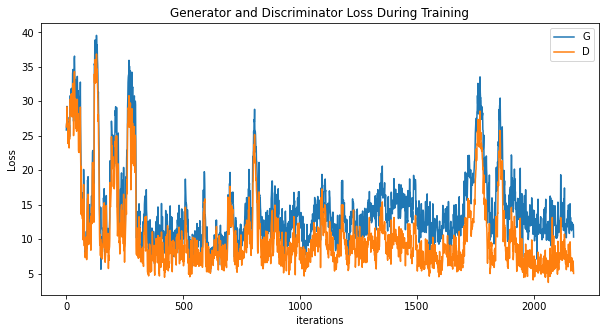

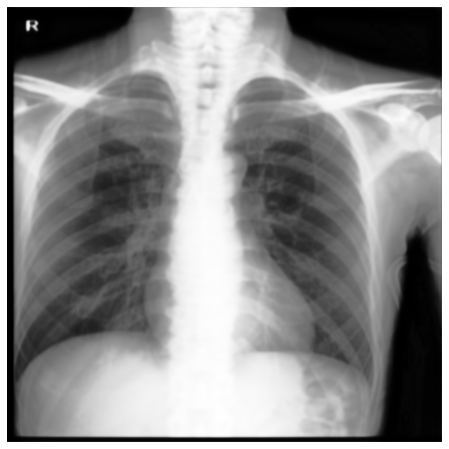

In [5]:
# SAVE WEIGHTS
torch.save(netG.state_dict(), PATH_G)
torch.save(netD.state_dict(), PATH_D)

# Plot G and D loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(output_save_directory, current_date + "training_loss"+".png"))
plt.show()

#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]


ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000, blit=True)
ani.save(os.path.join(output_save_directory, current_date+"generator_output.mp4"), dpi=300)

In [6]:


"""# TENSORBOARD Visualisation
writer = tensorboard.SummaryWriter(Path('runs/MSAGAN_v1'))

# get some random training images
dataiter = iter(dl_training)
sample = dataiter.next()
print(sample['source'].shape)
# create grid of images
img_grid = vutils.make_grid(sample['source'])

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('Images', img_grid)

writer.add_graph(netG, sample['source'])
writer.close()

%load_ext tensorboard
%tensorboard --logdir runs"""

"# TENSORBOARD Visualisation\nwriter = tensorboard.SummaryWriter(Path('runs/MSAGAN_v1'))\n\n# get some random training images\ndataiter = iter(dl_training)\nsample = dataiter.next()\nprint(sample['source'].shape)\n# create grid of images\nimg_grid = vutils.make_grid(sample['source'])\n\n# show images\nmatplotlib_imshow(img_grid, one_channel=True)\n\n# write to tensorboard\nwriter.add_image('Images', img_grid)\n\nwriter.add_graph(netG, sample['source'])\nwriter.close()\n\n%load_ext tensorboard\n%tensorboard --logdir runs"